In [19]:
import os
import math
import json
import codecs
import numpy as np
from numpy import log, exp
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as LR
from scipy.optimize import minimize
from scipy.stats import spearmanr, pearsonr, gaussian_kde

In [2]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

def logit(p):
    return log(p) - log(1 - p)

In [3]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class LinearRegression(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose 

    def __call__(self, valid_preacts, valid_labels):
        lr = LR().fit(valid_preacts.reshape(-1, 1), valid_labels)
    
        def calibration_func(preact):
            return lr.predict(preact.reshape(-1, 1))

        return calibration_func

In [4]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class SigmoidFit(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def __call__(self, valid_preacts, valid_labels):
        def loss_func(x):
            new_preacts = (x[0]*sigmoid(-valid_labels+x[1]))+x[2]
            return mean_squared_error(new_preacts, valid_preacts)

        x0 = np.array([1.0, 0.0, 0.0])
        res = None
        for c in range(10):
            curr = minimize(loss_func, x0, method='BFGS', options={'gtol': 1e-9, 'disp': True, 'maxiter': 1000})
            if res == None or curr.fun < res.fun:
                res = curr
        print("multiplier: ",res.x[0],", in sigmoid bias: ",res.x[1],", out of sigmoid bias: ",res.x[2])

        def calibration_func(label):
            return (res.x[0]*sigmoid(-label+res.x[1]))+res.x[2]

        def inv_func(preact):
            return -logit((preact-res.x[2])/res.x[0])+res.x[1]

        return calibration_func, inv_func

load the data

In [5]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)
        allFlanks.append(flank)

In [6]:
obj_text1 = codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToPho4CountPreds = json.loads(obj_text1)

In [7]:
obj_text2 = codecs.open("data/preds/pbexo.cbf1.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToPBCbf1Preds = json.loads(obj_text2)

In [8]:
obj_text3 = codecs.open("data/preds/limited.cbf1.eth.logCounts_fixed_min.json", 'r', encoding='utf-8').read()
flankToChPCbf1Preds = json.loads(obj_text3)

sampling and processing

In [9]:
sampled_keys = np.random.choice(allFlanks, 110000, replace=False)
sampled_valid_keys = sampled_keys[100000:]
sampled_keys = sampled_keys[:100000]

In [10]:
samplePho4CountPreds = {}
samplePBCbf1Preds = {}
sampleChPCbf1Preds = {}
samplePho4LogCountPreds = {}
samplePBCbf1LogPreds = {}
sampleChPCbf1LogPreds = {}
for key in sampled_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4LogCountPreds[key] = np.mean(y_1-y_0)
    samplePho4CountPreds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_0 = np.array(flankToPBCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToPBCbf1Preds[key][1]).astype(float)
    samplePBCbf1LogPreds[key] = np.mean(y_1-y_0)
    samplePBCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_1 = np.array(flankToChPCbf1Preds[key]).astype(float)
    sampleChPCbf1LogPreds[key] = np.mean(y_1)
    sampleChPCbf1Preds[key] = np.mean(np.exp(y_1)-1)
for key in sampled_valid_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4LogCountPreds[key] = np.mean(y_1-y_0)
    samplePho4CountPreds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_0 = np.array(flankToPBCbf1Preds[key][0]).astype(float)
    y_1 = np.array(flankToPBCbf1Preds[key][1]).astype(float)
    samplePBCbf1LogPreds[key] = np.mean(y_1-y_0)
    samplePBCbf1Preds[key] = np.mean(np.exp(y_1)-np.exp(y_0))
    y_1 = np.array(flankToChPCbf1Preds[key]).astype(float)
    sampleChPCbf1LogPreds[key] = np.mean(y_1)
    sampleChPCbf1Preds[key] = np.mean(np.exp(y_1)-1)

plotting code

In [11]:
%matplotlib inline

def plotCorrs(xvals, yvals, xlabel, ylabel):
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    axes = plt.gca()
    p, residuals, _, _, _ = np.polyfit(xvals, yvals, 1, full=True)
    m, b = p
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("spearman: "+str(spearmanr(xvals, yvals))+
              ", pearson: "+str(pearsonr(xvals, yvals))+
              ", residuals: "+str(residuals))
    plt.show()

Pho4 sample

In [12]:
valid_log_preacts = []
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_log_preacts.append(samplePho4LogCountPreds[key])
    valid_preacts.append(samplePho4CountPreds[key])
    valid_labels.append(flankToPho4Ddg[key])
valid_log_preacts = np.array(valid_log_preacts)
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

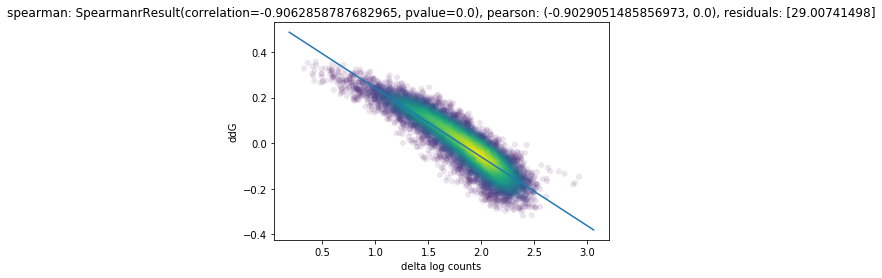

In [13]:
plotCorrs(valid_log_preacts, valid_labels, "delta log counts", "ddG")

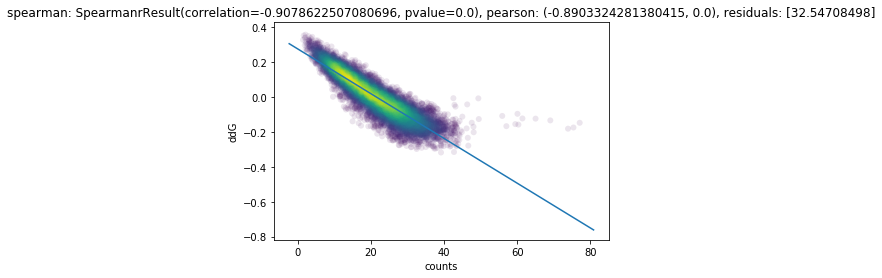

In [14]:
plotCorrs(valid_preacts, valid_labels, "counts", "ddG")

Pho4 baseline evaluation

In [15]:
log_preacts = []
preacts = []
labels = []
for key in sampled_keys:
    log_preacts.append(samplePho4LogCountPreds[key])
    preacts.append(samplePho4CountPreds[key])
    labels.append(flankToPho4Ddg[key])
log_preacts = np.array(log_preacts)
preacts = np.array(preacts)
labels = np.array(labels)

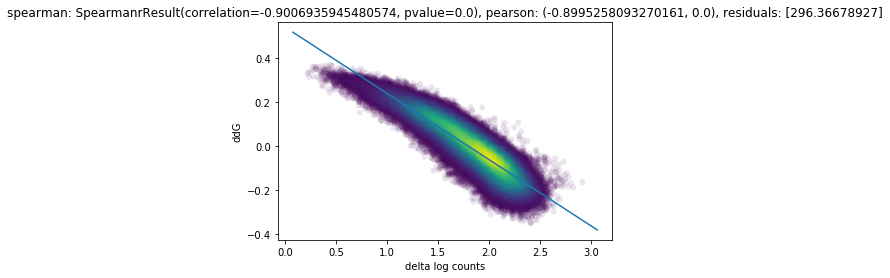

In [16]:
plotCorrs(log_preacts, labels, "delta log counts", "ddG")

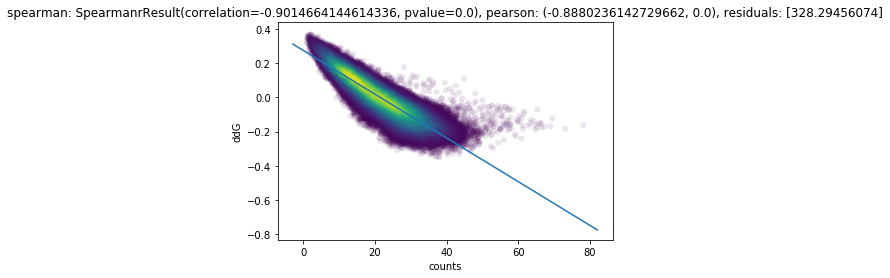

In [17]:
plotCorrs(preacts, labels, "counts", "ddG")

Pho4 linear fit with counts

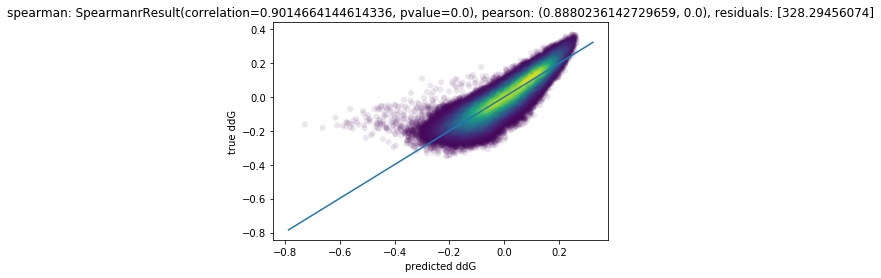

In [20]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Pho4 linear fit with log counts

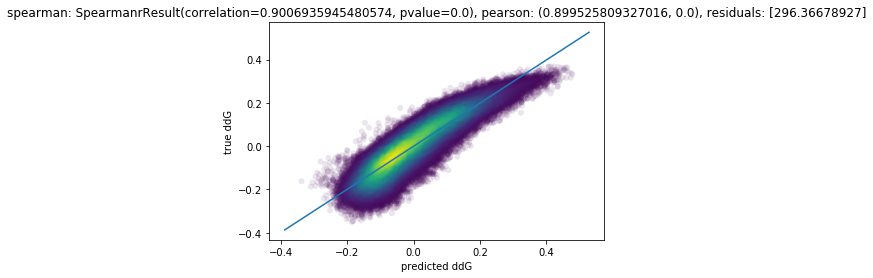

In [21]:
lr = LinearRegression()
calibration_func = lr(valid_log_preacts, valid_labels)
calibrated_labels = calibration_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Pho4 logit fit with counts

         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 15.663313
         Iterations: 128
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 1

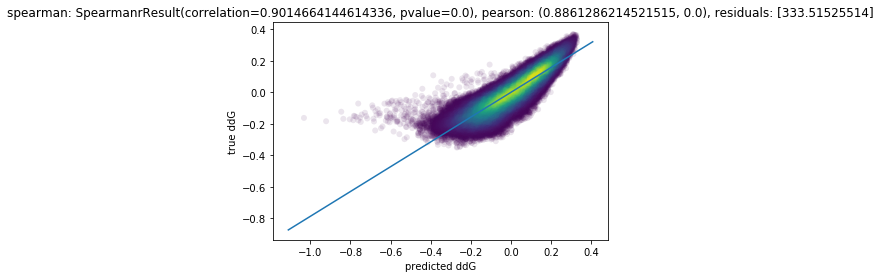

In [22]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = inv_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

Pho4 logit fit with log counts

         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0.023520
         Iterations: 456
         Function evaluations: 3519
         Gradient evaluations: 702
         Current function value: 0

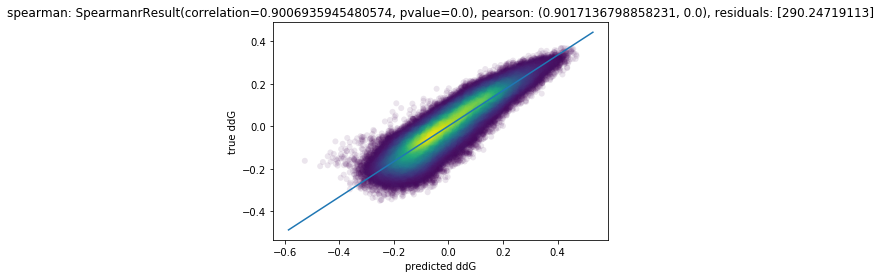

In [23]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_log_preacts, valid_labels)
calibrated_labels = inv_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

PBexo Cbf1 sample

In [24]:
valid_log_preacts = []
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_log_preacts.append(samplePBCbf1LogPreds[key])
    valid_preacts.append(samplePBCbf1Preds[key])
    valid_labels.append(flankToCbf1Ddg[key])
valid_log_preacts = np.array(valid_log_preacts)
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

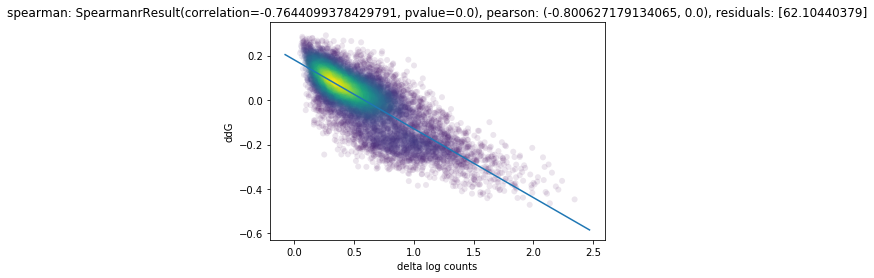

In [25]:
plotCorrs(valid_log_preacts, valid_labels, "delta log counts", "ddG")

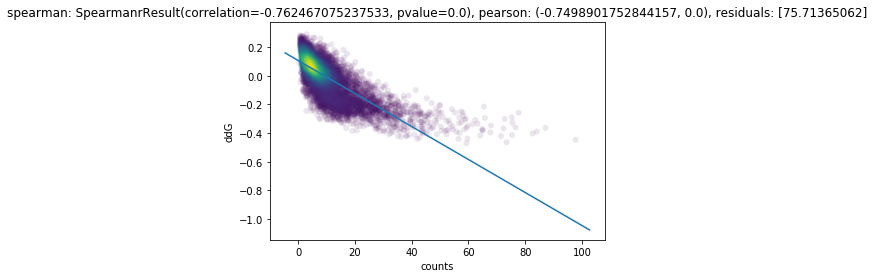

In [26]:
plotCorrs(valid_preacts, valid_labels, "counts", "ddG")

PBexo Cbf1 baseline

In [27]:
log_preacts = []
preacts = []
labels = []
for key in sampled_keys:
    log_preacts.append(samplePBCbf1LogPreds[key])
    preacts.append(samplePBCbf1Preds[key])
    labels.append(flankToCbf1Ddg[key])
log_preacts = np.array(log_preacts)
preacts = np.array(preacts)
labels = np.array(labels)

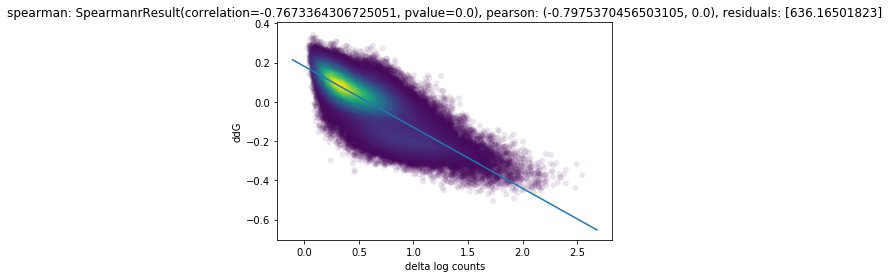

In [28]:
plotCorrs(log_preacts, labels, "delta log counts", "ddG")

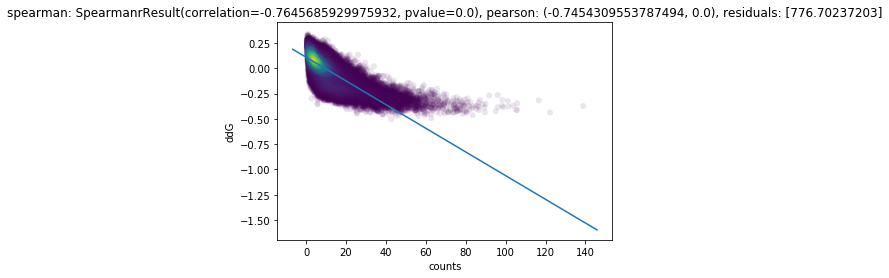

In [29]:
plotCorrs(preacts, labels, "counts", "ddG")

PBexo Cbf1 linear fit with counts

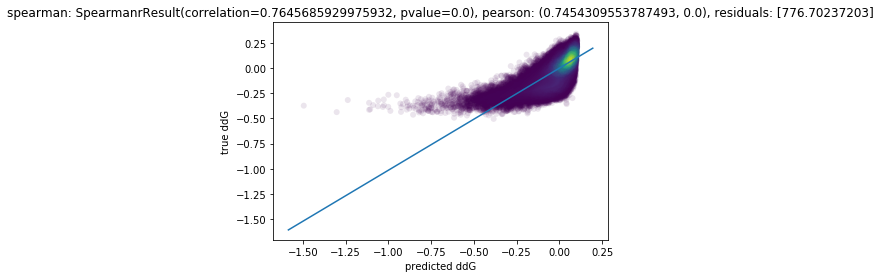

In [30]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

PBexo Cbf1 linear fit with log counts

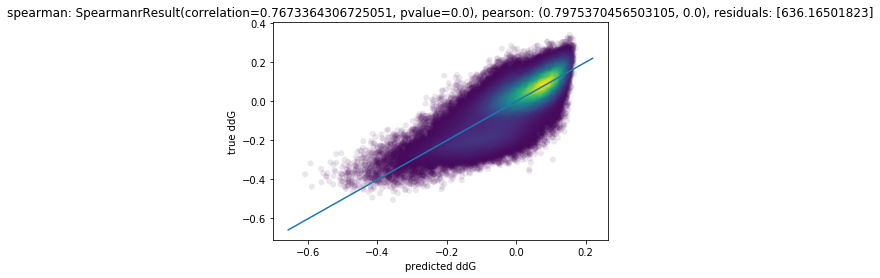

In [31]:
lr = LinearRegression()
calibration_func = lr(valid_log_preacts, valid_labels)
calibrated_labels = calibration_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

PBexo Cbf1 logit fit with counts

         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function value: 30.036149
         Iterations: 360
         Function evaluations: 2832
         Gradient evaluations: 564
         Current function v

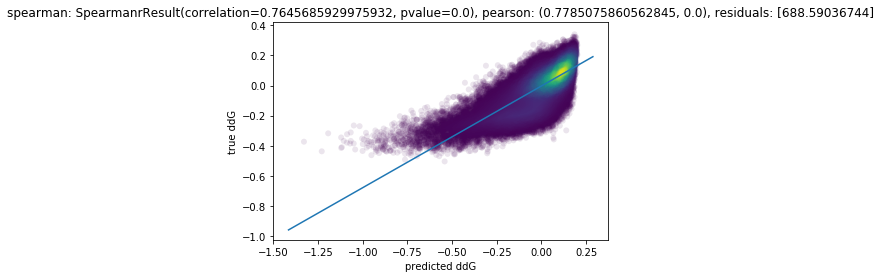

In [32]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = inv_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

PBexo Cbf1 logit fit with log counts

         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function value: 0.040445
         Iterations: 775
         Function evaluations: 5236
         Gradient evaluations: 1047
         Current function v

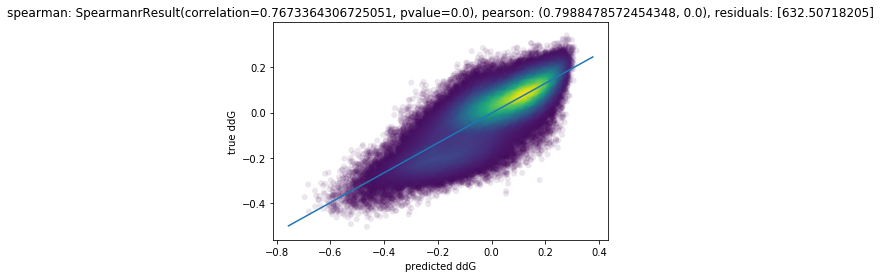

In [33]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_log_preacts, valid_labels)
calibrated_labels = inv_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

ChIPexo Cbf1 sample

In [34]:
valid_log_preacts = []
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_log_preacts.append(sampleChPCbf1LogPreds[key])
    valid_preacts.append(sampleChPCbf1Preds[key])
    valid_labels.append(flankToCbf1Ddg[key])
valid_log_preacts = np.array(valid_log_preacts)
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

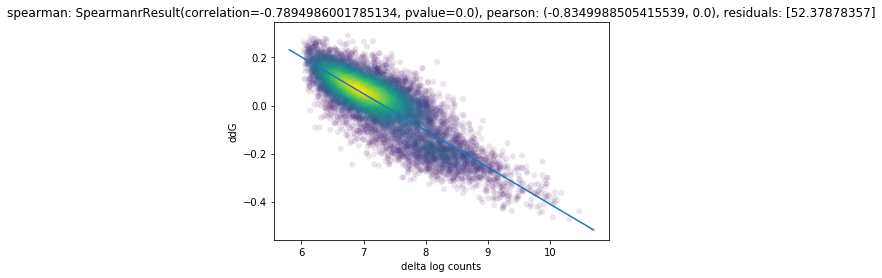

In [35]:
plotCorrs(valid_log_preacts, valid_labels, "delta log counts", "ddG")

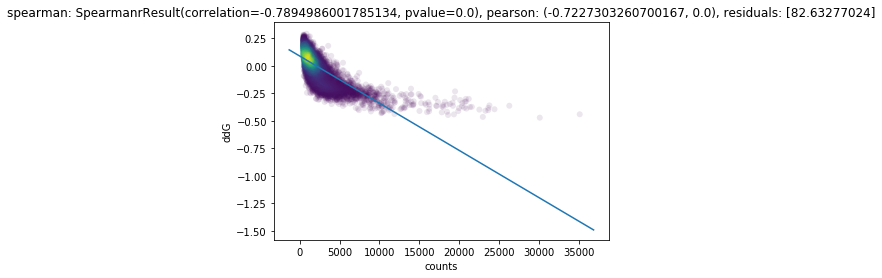

In [36]:
plotCorrs(valid_preacts, valid_labels, "counts", "ddG")

ChIPexo Cbf1 baseline

In [37]:
log_preacts = []
preacts = []
labels = []
for key in sampled_keys:
    log_preacts.append(sampleChPCbf1LogPreds[key])
    preacts.append(sampleChPCbf1Preds[key])
    labels.append(flankToCbf1Ddg[key])
log_preacts = np.array(log_preacts)
preacts = np.array(preacts)
labels = np.array(labels)

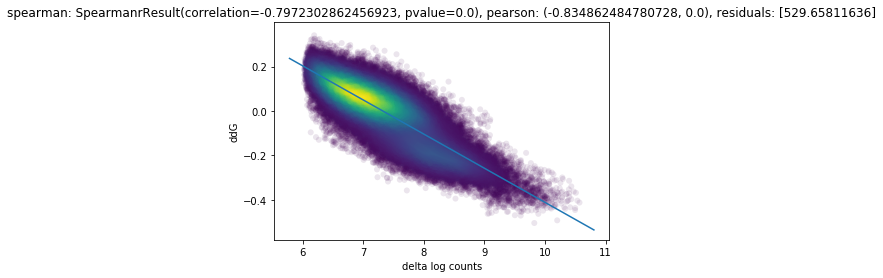

In [38]:
plotCorrs(log_preacts, labels, "delta log counts", "ddG")

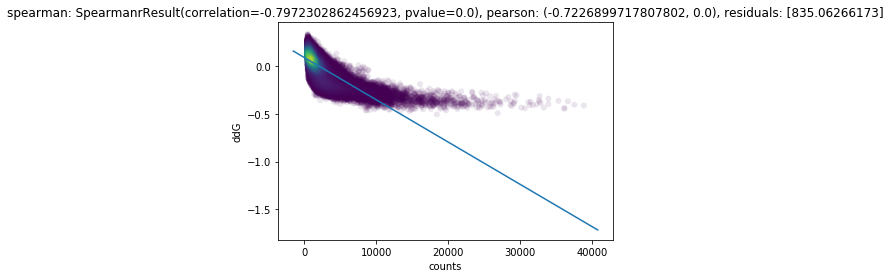

In [39]:
plotCorrs(preacts, labels, "counts", "ddG")

ChIPexo Cbf1 linear fit with counts

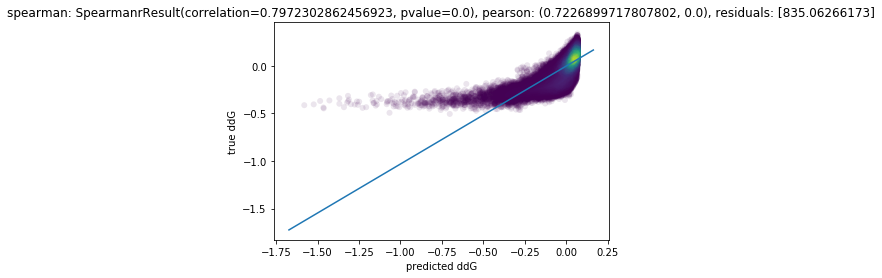

In [40]:
lr = LinearRegression()
calibration_func = lr(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

ChIPexo Cbf1 linear fit with log counts

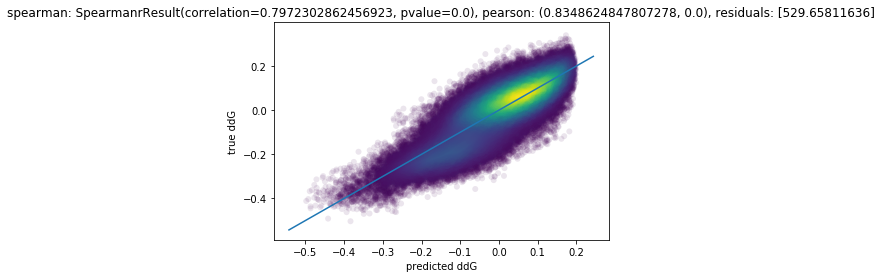

In [41]:
lr = LinearRegression()
calibration_func = lr(valid_log_preacts, valid_labels)
calibrated_labels = calibration_func(log_preacts)
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")

ChIPexo Cbf1 logit fit with counts

In [47]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = inv_func(preacts)

Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 4909859.052028
         Iterations: 4
      

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


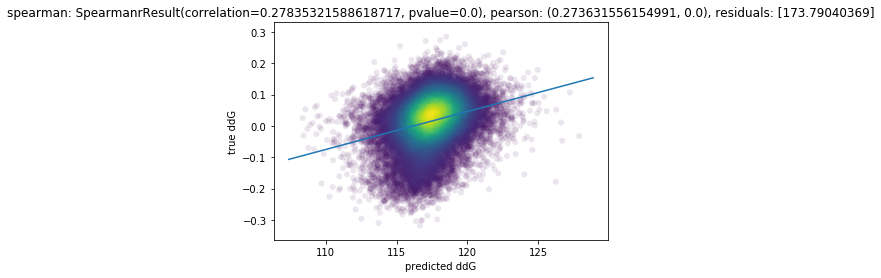

In [48]:
from numpy import inf, isnan
edit_labels = []
edit_preds = []
for idx, val in enumerate(calibrated_labels):
    if val == inf or isnan(val): continue
    edit_preds.append(calibrated_labels[idx])
    edit_labels.append(labels[idx])
plotCorrs(edit_preds, edit_labels, "predicted ddG", "true ddG")

ChIPexo Cbf1 logit fit with log counts

In [49]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_log_preacts, valid_labels)
calibrated_labels = inv_func(log_preacts)

         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function value: 0.152890
         Iterations: 786
         Function evaluations: 5376
         Gradient evaluations: 1075
         Current function v

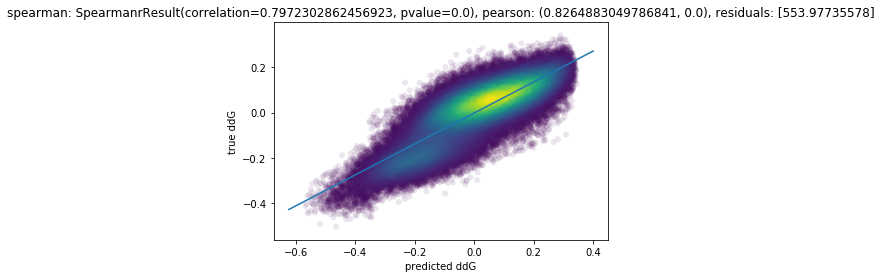

In [52]:
plotCorrs(calibrated_labels, labels, "predicted ddG", "true ddG")